In [ ]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

import warnings
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from enum import Enum
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

from data.dataset_utils import load_data, Subjects
from mp import stump_for_subjects, mpdist_for_subjects, multi_stump_for_subjects
from thresholds import test_supervised_acc_threshold ,train_supervised_acc_threshold, fixed_percentile_threshold, mixmod_threshold, filter_threshold, karch_threshold, eb_threshold

In [2]:
df = load_data(filtered=True)

In [3]:
# plot the distribution of the scores
def plot_histogram(subjects_scores_0, subjects_scores_1, thresholds):
    # shift all thresholds to zero
    scores_0 = np.concatenate([scores - thresholds[i] for i, scores in enumerate(subjects_scores_0)])
    scores_1 = np.concatenate([scores - thresholds[i] for i, scores in enumerate(subjects_scores_1)])

    range = (min(np.concatenate([scores_0, scores_1])), max(np.concatenate([scores_0, scores_1])))
    
    plt.hist(scores_0, bins=80, alpha=0.5, range= range, label='Normal')
    plt.hist(scores_1, bins=80, alpha=0.5, range= range, label='Anomalous')
    plt.axvline(x=0, color='black', linestyle='--', label='Threshold')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
    plt.show()

In [4]:
class AlgorithmType(Enum):
    STUMP = 1
    MPDIST = 2
    MULTI_STUMP = 3

def evaluate(subjects_scores_0, subjects_scores_1, threshold_func, percentile = None):
    metrics = {'acc': [], 'prec': [], 'rec': [], 'auc': [], 'threshold': [], 'percentile': []}
    for scores_0, scores_1 in zip(subjects_scores_0, subjects_scores_1):
        y_true = np.concatenate([np.zeros(len(scores_0)), np.ones(len(scores_1))])
        y_scores = np.concatenate([scores_0, scores_1])
        y_normal_scores = y_scores[y_true == 0]

        thresholds = []
        percentile_train_normal = []
        if threshold_func.__name__ == 'test_supervised_acc_threshold' or threshold_func.__name__ == 'train_supervised_acc_threshold' or threshold_func.__name__ == 'fixed_percentile_threshold':
            y_pred = []
            for i in range(len(y_true)):
                y_train_scores = np.delete(y_scores, i)
                y_train_true = np.delete(y_true, i)
                y_train_normal_scores = y_train_scores[y_train_true == 0]

                if threshold_func.__name__ == 'test_supervised_acc_threshold':
                    threshold = threshold_func(y_scores, y_true)
                    percentile_train_normal.append(np.sum(y_normal_scores < threshold) / len(y_normal_scores) * 100)
                elif threshold_func.__name__ == 'train_supervised_acc_threshold':
                    threshold = threshold_func(y_train_scores, y_train_true)
                    percentile_train_normal.append(np.sum(y_train_normal_scores < threshold) / len(y_train_normal_scores) * 100)
                elif threshold_func.__name__ == 'fixed_percentile_threshold':
                    threshold = threshold_func(y_train_normal_scores, percentile)

                y_pred.append(int(y_scores[i] > threshold))
                thresholds.append(threshold)
        else:
            y_train_normal_scores = y_scores[y_true == 0]
            
            # min-max normalize
            max_normal = np.max(y_train_normal_scores)
            min_normal = np.min(y_train_normal_scores)
            if max_normal == min_normal:
                thresholds.append(0)
            else:
                y_train_normal_scores = (y_train_normal_scores - min_normal) / (max_normal - min_normal)

                threshold = threshold_func(y_train_normal_scores)

                # denormalize the threshold
                threshold = threshold * (max_normal - min_normal) + min_normal
            y_pred = y_scores > threshold
            thresholds.append(threshold)

        metrics['acc'].append(accuracy_score(y_true, y_pred))
        metrics['prec'].append(precision_score(y_true, y_pred, zero_division=0))
        metrics['rec'].append(recall_score(y_true, y_pred))
        metrics['auc'].append(roc_auc_score(y_true, y_scores))
        metrics['threshold'].append(np.mean(thresholds))
        metrics['percentile'].append(np.mean(percentile_train_normal) if percentile_train_normal else np.nan)
    
    thresholds = metrics['threshold']

    # Calculate the mean and std for each metric
    metric_means_stds = {k: (np.mean(v), np.std(v)) for k, v in metrics.items()}

    # Create a DataFrame row with a MultiIndex
    index = pd.MultiIndex.from_tuples([(metric, stat) for metric in metrics.keys() for stat in ['avg', 'std']], names=[None, None])
    data = [metric_means_stds[k][i] for k in metrics.keys() for i in range(2)]
    df_row = pd.DataFrame([data], columns=index)

    return df_row, (thresholds, round(np.mean(metrics['percentile']), 1))

def mpd(subjects, class_id, signal, m, algorithmType, tb_indices=None, percentile=None):
    if algorithmType == AlgorithmType.STUMP:
        mps_0, mps_1, scores_0, scores_1 = stump_for_subjects(df, subjects, class_id, signal, m, tb_indices)
    elif algorithmType == AlgorithmType.MPDIST:
        scores_0, scores_1 = mpdist_for_subjects(df, subjects, class_id, signal, m)
    elif algorithmType == AlgorithmType.MULTI_STUMP:
        mps_0, mps_1, scores_0, scores_1 = multi_stump_for_subjects(df, subjects, class_id, signal, m, tb_indices)
    
    # Initialize the results DataFrame
    metrics = ['acc', 'prec', 'rec', 'auc', 'threshold', 'percentile']
    stats = ['avg', 'std']
    index = pd.MultiIndex.from_product([metrics, stats], names=[None, None])
    results_df = pd.DataFrame(columns=index)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        df_row_1, (thresholds, p) = evaluate(scores_0, scores_1, test_supervised_acc_threshold, percentile)
        df_row_1.index = ['test supervised acc']
        results_df = pd.concat([results_df, df_row_1])

        df_row_2, _ = evaluate(scores_0, scores_1, train_supervised_acc_threshold, percentile)
        df_row_2.index = ['train supervised acc']
        results_df = pd.concat([results_df, df_row_2])

        percentile = p if percentile is None else percentile
        df_row_3, _ = evaluate(scores_0, scores_1, fixed_percentile_threshold, percentile)
        df_row_3.index = [f'{percentile}-th percentile']
        results_df = pd.concat([results_df, df_row_3])

        df_row_4, _ = evaluate(scores_0, scores_1, mixmod_threshold, percentile)
        df_row_4.index = ['mixmod']
        results_df = pd.concat([results_df, df_row_4])

        df_row_5, _ = evaluate(scores_0, scores_1, filter_threshold, percentile)
        df_row_5.index = ['filter']
        results_df = pd.concat([results_df, df_row_5])

        df_row_6, _ = evaluate(scores_0, scores_1, karch_threshold, percentile)
        df_row_6.index = ['karch']
        results_df = pd.concat([results_df, df_row_6])

        df_row_7, _ = evaluate(scores_0, scores_1, eb_threshold, percentile)
        df_row_7.index = ['eb']
        results_df = pd.concat([results_df, df_row_7])

    return results_df, scores_0, scores_1, thresholds

# STUMP

## GSR (0,4)

acc                prec                 rec  \
                           avg       std       avg       std       avg   
test supervised acc   0.773851  0.119018  0.758694  0.113928  0.833908   
train supervised acc  0.698276  0.167289  0.672333  0.155983  0.767241   
66.2-th percentile    0.691092  0.120641  0.653890  0.108614  0.736207   
mixmod                0.716379  0.135868  0.709182  0.144405  0.695977   
filter                0.619253  0.146644  0.631237  0.263229  0.357471   
karch                 0.665517  0.156756  0.682474  0.201192  0.504023   
eb                    0.640517  0.133705  0.652441  0.189251  0.548276   

                                    auc            threshold             \
                           std      avg       std        avg        std   
test supervised acc   0.204334  0.75194  0.145619   9.343348   6.155753   
train supervised acc  0.239951  0.75194  0.145619   9.380204   5.942934   
66.2-th percentile    0.239694  0.75194  0.145619   8.699393   4.842022   
mixmod                0.272200  0.75194  0.145619  10.708817   5.819635   
filter                0.286730  0.75194  0.145619  20.356047   7.716387   
karch                 0.286398  0.75194  0.145619  15.304646   5.095577   
eb                    0.272436  0.75194  0.145619  15.944162  11.663340   

                     percentile             
                            avg        std  
test supervised acc   66.206897  19.549018  
train supervised acc  66.464534  18.407604  
66.2-th percentile          NaN        NaN  
mixmod                      NaN        NaN  
filter                      NaN        NaN  
karch                       NaN        NaN  
eb                          NaN        NaN

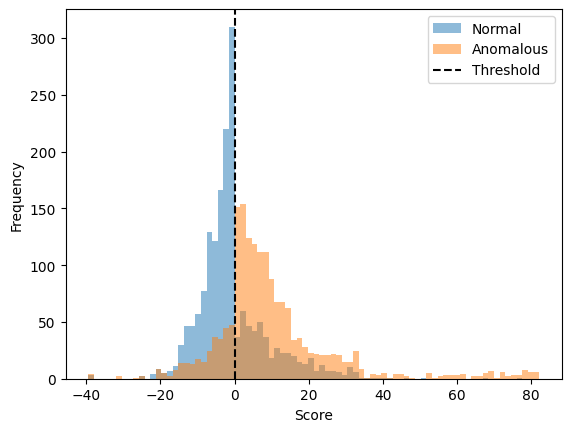

In [ ]:
results_df, scores_0, scores_1, thresholds = mpd(subjects=Subjects.all, class_id=4, signal='gsr', m=2000, algorithmType=AlgorithmType.STUMP)

display(results_df)
plot_histogram(scores_0, scores_1, thresholds)

## ECG (0,4)

acc                prec                 rec  \
                           avg       std       avg       std       avg   
test supervised acc   0.747414  0.138601  0.756459  0.162093  0.756897   
train supervised acc  0.657471  0.213486  0.636961  0.236384  0.672414   
68.8-th percentile    0.668966  0.136087  0.635759  0.129874  0.668391   
mixmod                0.651724  0.149510  0.656267  0.207027  0.526437   
filter                0.631322  0.158713  0.636682  0.307035  0.348851   
karch                 0.654023  0.157060  0.671371  0.209542  0.462644   
eb                    0.612644  0.146750  0.571230  0.244323  0.505172   

                                     auc          threshold            \
                           std       avg      std       avg       std   
test supervised acc   0.240470  0.725805  0.18729  1.998001  0.900266   
train supervised acc  0.289843  0.725805  0.18729  2.009710  0.885871   
68.8-th percentile    0.274083  0.725805  0.18729  1.877166  0.756795   
mixmod                0.320635  0.725805  0.18729  2.195942  0.904215   
filter                0.327388  0.725805  0.18729  2.880549  1.516721   
karch                 0.318060  0.725805  0.18729  2.330128  0.923311   
eb                    0.350290  0.725805  0.18729  2.765840  2.110750   

                     percentile             
                            avg        std  
test supervised acc   68.793103  21.826978  
train supervised acc  69.456594  18.719535  
68.8-th percentile          NaN        NaN  
mixmod                      NaN        NaN  
filter                      NaN        NaN  
karch                       NaN        NaN  
eb                          NaN        NaN

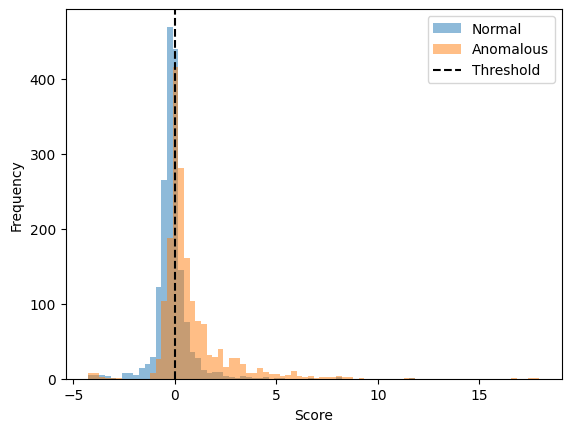

In [ ]:
results_df, scores_0, scores_1, thresholds = mpd(subjects=Subjects.all, class_id=4, signal='ecg', m=400, algorithmType=AlgorithmType.STUMP)

display(results_df)
plot_histogram(scores_0, scores_1, thresholds)

## EMG (0,4)

acc                prec                 rec  \
                           avg       std       avg       std       avg   
test supervised acc   0.637931  0.100492  0.664809  0.206238  0.627586   
train supervised acc  0.517241  0.183293  0.494792  0.230245  0.488506   
57.7-th percentile    0.553161  0.114834  0.522704  0.139030  0.513218   
mixmod                0.552874  0.103072  0.535260  0.156065  0.551149   
filter                0.549138  0.110994  0.483346  0.295844  0.217816   
karch                 0.558046  0.116430  0.537820  0.193255  0.365517   
eb                    0.521839  0.086254  0.517896  0.145033  0.667816   

                                    auc            threshold            \
                           std      avg       std        avg       std   
test supervised acc   0.305952  0.57773  0.158659  21.077836  5.320380   
train supervised acc  0.293777  0.57773  0.158659  21.095296  5.153211   
57.7-th percentile    0.252056  0.57773  0.158659  20.563347  6.383297   
mixmod                0.277818  0.57773  0.158659  21.438387  3.672056   
filter                0.236835  0.57773  0.158659  23.159403  4.164870   
karch                 0.248826  0.57773  0.158659  21.848466  4.954884   
eb                    0.259528  0.57773  0.158659  20.857077  3.430254   

                     percentile             
                            avg        std  
test supervised acc   57.701149  29.631885  
train supervised acc  59.035163  25.646279  
57.7-th percentile          NaN        NaN  
mixmod                      NaN        NaN  
filter                      NaN        NaN  
karch                       NaN        NaN  
eb                          NaN        NaN

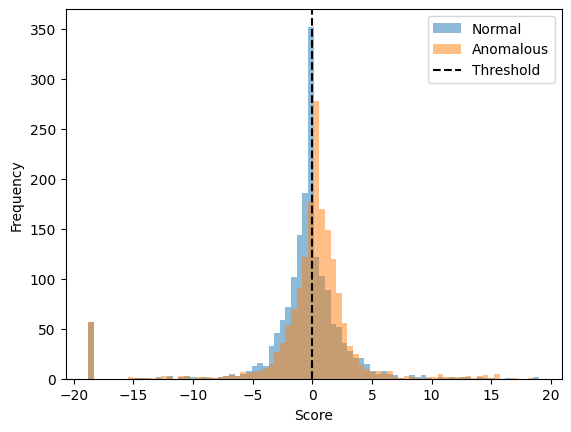

In [ ]:
results_df, scores_0, scores_1, thresholds = mpd(subjects=Subjects.all, class_id=4, signal='emg_trapezius', m=500, algorithmType=AlgorithmType.STUMP)

display(results_df)
plot_histogram(scores_0, scores_1, thresholds)

## ECG (0,4) for a specific subject

In [ ]:
def show_extremes(subject, signal, m, max_normal=0, min_normal=1000, max_anomaly=0, min_anomaly=1000):
    print('\n' + subject)

    mps_0, mps_1, scores_0, scores_1 = stump_for_subjects(df, [subject], 4, signal, m)

    #display(pd.DataFrame({'normal': scores_0[0], 'anomaly': scores_1[0]}))

    normal_data = df.query("class_id == 0 and subject_name == @subject")['bio_signals'].apply(lambda signals: signals.get(signal).values)
    anomaly_data = df.query("class_id == 4 and subject_name == @subject")['bio_signals'].apply(lambda signals: signals.get(signal).values)

    i_max_normal = np.argmax(scores_0[0])
    i_min_normal = np.argmin(scores_0[0])
    i_max_anomaly = np.argmax(scores_1[0])
    i_min_anomaly = np.argmin(scores_1[0])

    print(f'Max normal: {scores_0[0][i_max_normal]}, index: {i_max_normal}')
    print(f'Min normal: {scores_0[0][i_min_normal]}, index: {i_min_normal}')
    print(f'Max anomaly: {scores_1[0][i_max_anomaly]}, index: {i_max_anomaly}')
    print(f'Min anomaly: {scores_1[0][i_min_anomaly]}, index: {i_min_anomaly}')

    # distribution of the scores
    #range = (min(np.concatenate((scores_0[0], scores_1[0])))), max(np.concatenate((scores_0[0], scores_1[0])))
    #plt.hist(scores_0, bins=50, alpha=0.5, range= range, label='normal')
    #plt.hist(scores_1, bins=50, alpha=0.5, range= range, label='anomaly')
    #plt.xlabel('Score')
    #plt.ylabel('Frequency')
    #plt.legend(loc='upper right')
    #plt.show() 

    # plot the time series and matrix profile of the most extreme samples
    xlim = normal_data.iloc[0].shape[0] # length of the time series
    #ylim = max(max(mps_0[0][i_max_normal]), max(mps_1[0][i_max_anomaly])) # highest mp value
    ylim = 20

    if min_normal > scores_0[0][i_min_normal]:
        plot_series_and_profile(normal_data, mps_0[0], i_min_normal, f'Normal sample with an Anomaly Score of {scores_0[0][i_min_normal]:.2f}', xlim, ylim, signal)
        min_normal = scores_0[0][i_min_normal]

    if max_normal < scores_0[0][i_max_normal]:
        plot_series_and_profile(normal_data, mps_0[0], i_max_normal, f'Normal sample with an Anomaly Score of {scores_0[0][i_max_normal]:.2f}', xlim, ylim, signal)
        max_normal = scores_0[0][i_max_normal]

    if min_anomaly > scores_1[0][i_min_anomaly]:
        plot_series_and_profile(anomaly_data, mps_1[0], i_min_anomaly, f'Anomaly sample with an Anomaly Score of {scores_1[0][i_min_anomaly]:.2f}', xlim, ylim, signal)
        min_anomaly = scores_1[0][i_min_anomaly]

    if max_anomaly < scores_1[0][i_max_anomaly]:
        plot_series_and_profile(anomaly_data, mps_1[0], i_max_anomaly, f'Anomaly sample with an Anomaly Score of {scores_1[0][i_max_anomaly]:.2f}', xlim, ylim, signal)
        max_anomaly = scores_1[0][i_max_anomaly]

    return max_normal, min_normal, max_anomaly, min_anomaly


def plot_series_and_profile(data, mp, index, title, xlim, ylim, signal='signal'):
    fig, axs = plt.subplots(2, 1, figsize=(10, 4))
    # original time series
    axs[0].plot(data.iloc[index], label=signal)
    axs[0].set_xlim(0, xlim)
    axs[0].get_xaxis().set_visible(False)
    axs[0].set_title(title)
    axs[0].legend()
    # matrix profile
    axs[1].plot(mp[index], label='Matrix profile')
    axs[1].set_xlim(0, xlim)
    axs[1].set_ylim(0, ylim + (ylim * 0.1))
    axs[1].legend()

    plt.tight_layout()
    plt.show()


100914_m_39
Max normal: 1.578815488970836, index: 1
Min normal: 1.1135994781091212, index: 15
Max anomaly: 2.0485241292037424, index: 4
Min anomaly: 1.0887678650354784, index: 9


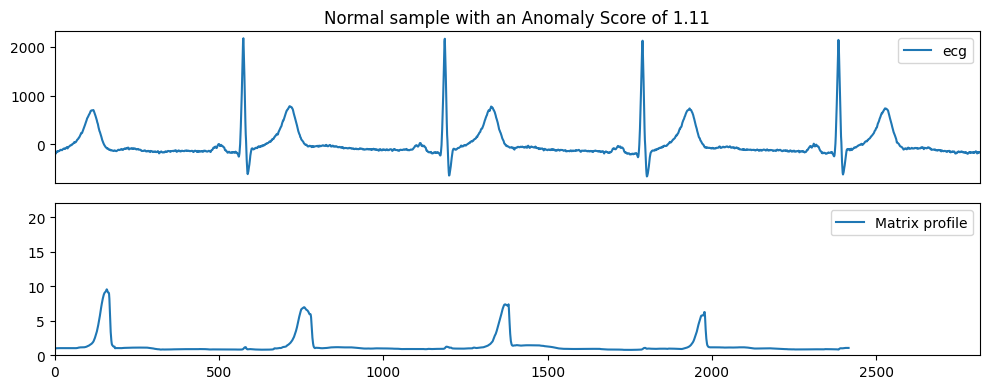

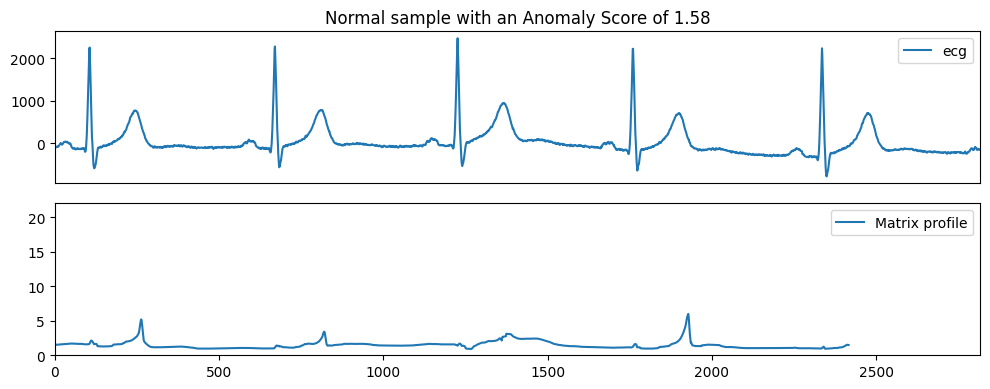

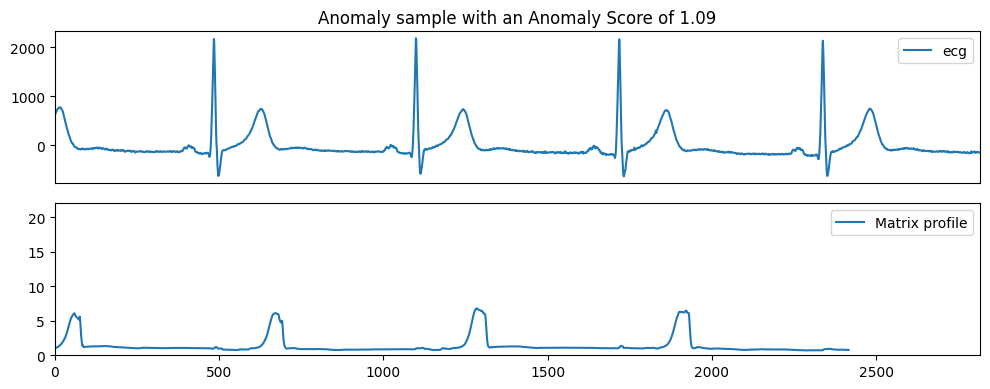

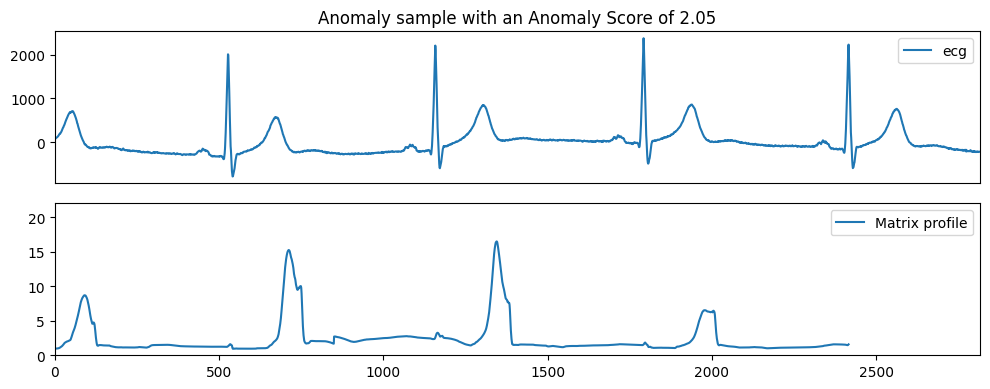


101114_w_37
Max normal: 2.58889793645904, index: 17
Min normal: 1.4105836121055357, index: 2
Max anomaly: 4.080742117482182, index: 14
Min anomaly: 1.2818798052199865, index: 12


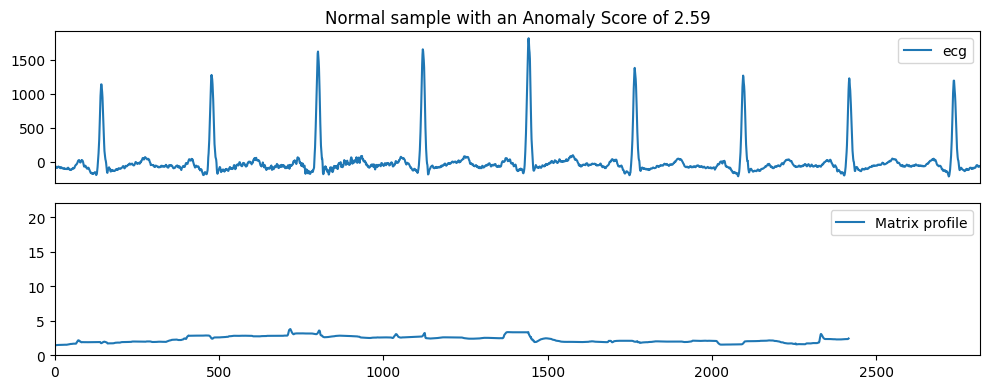

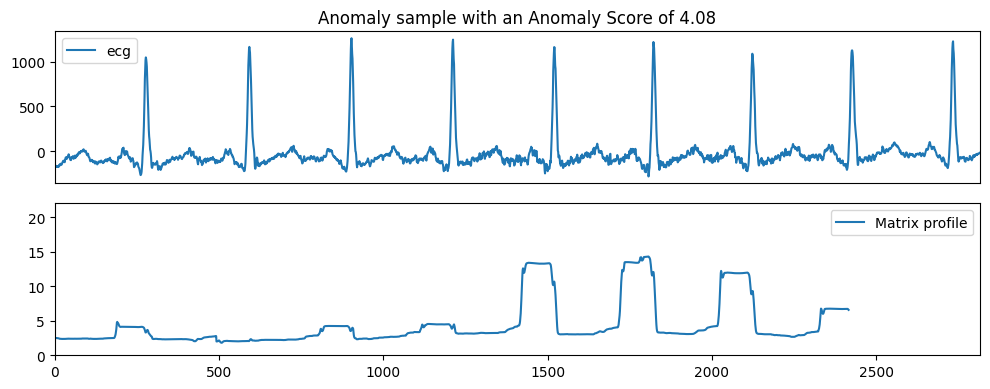


082315_w_60
Max normal: 6.413153329292344, index: 19
Min normal: 2.0494652888010125, index: 10
Max anomaly: 7.383839470831297, index: 1
Min anomaly: 2.2192444020290356, index: 9


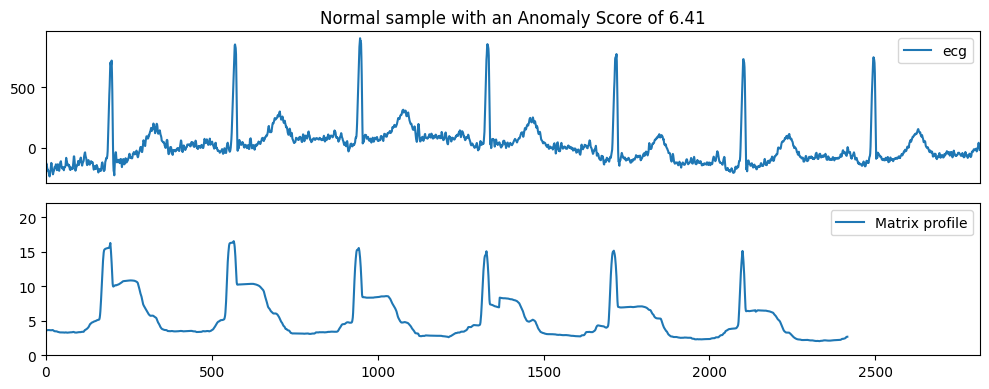

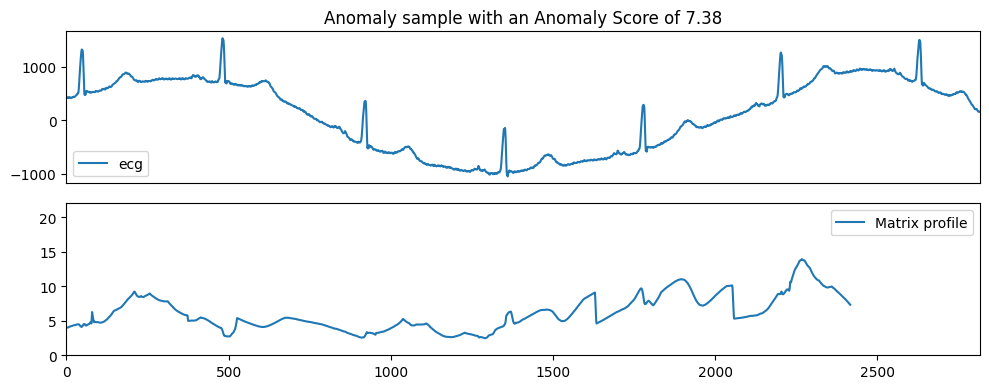


083114_w_55
Max normal: 2.4844504196768136, index: 15
Min normal: 1.4383459936369538, index: 9
Max anomaly: 1.9239807562701838, index: 17
Min anomaly: 1.393220180051384, index: 6

083109_m_60
Max normal: 2.896803369691103, index: 17
Min normal: 1.8374140229080131, index: 14
Max anomaly: 2.767328172595976, index: 12
Min anomaly: 1.7234046845376148, index: 13

072514_m_27
Max normal: 1.9669149207732957, index: 16
Min normal: 0.888843602419838, index: 19
Max anomaly: 1.525782146822005, index: 16
Min anomaly: 0.8536561115734211, index: 8


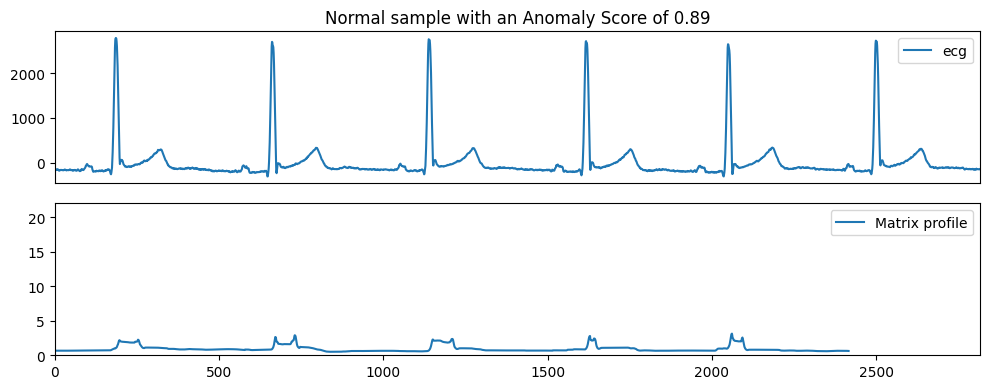

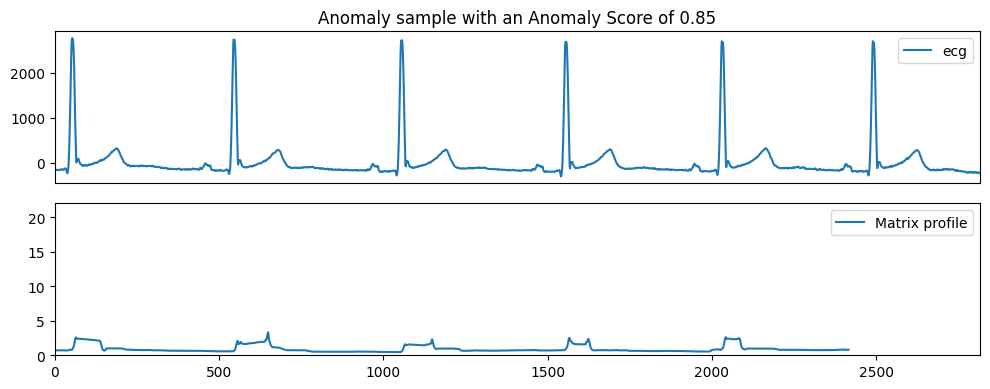


080309_m_29
Max normal: 0.9993844564976481, index: 10
Min normal: 0.5426013152503494, index: 14
Max anomaly: 1.7295818651206638, index: 7
Min anomaly: 0.7509681916975087, index: 1


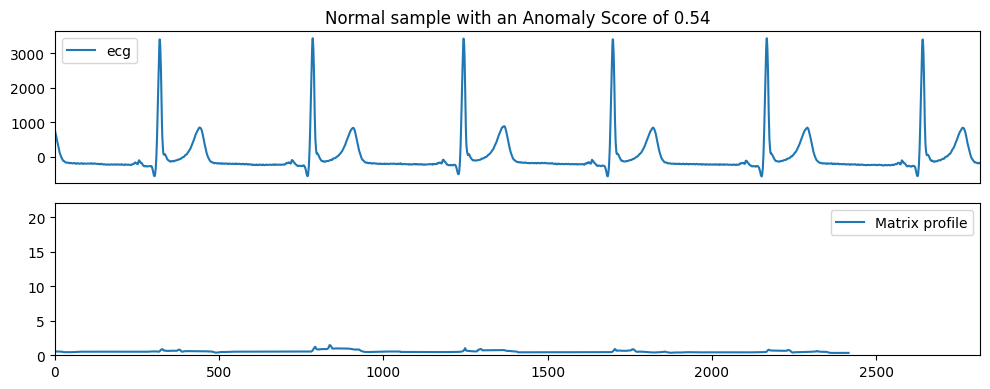

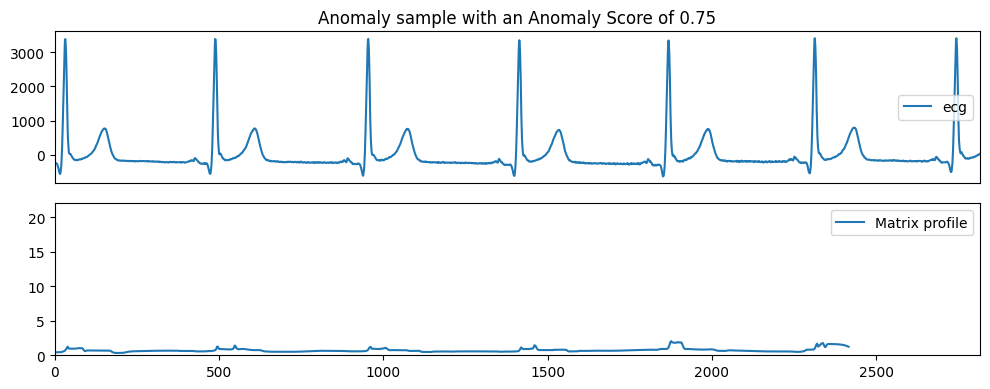


112016_m_25
Max normal: 7.331139756175665, index: 11
Min normal: 1.2107068380237977, index: 1
Max anomaly: 7.676378367959249, index: 0
Min anomaly: 1.2324785470655446, index: 16


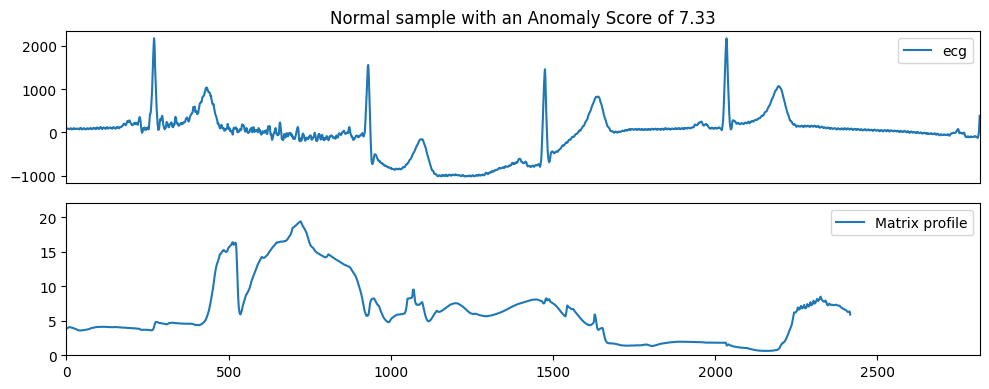

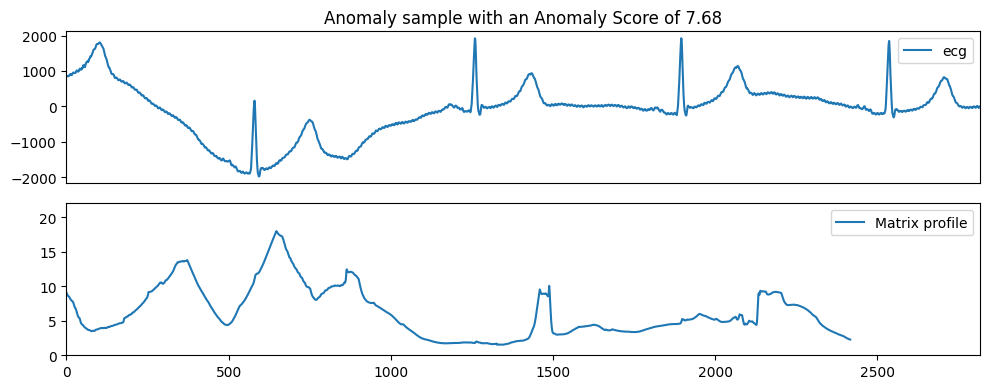


112310_m_20
Max normal: 6.104882187257019, index: 0
Min normal: 1.059853458314554, index: 4
Max anomaly: 13.20709515868429, index: 2
Min anomaly: 1.8152604693118908, index: 18


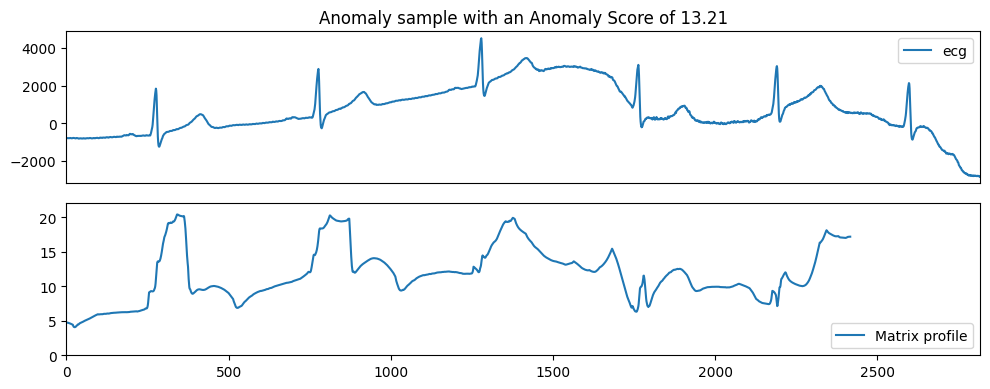


092813_w_24
Max normal: 3.7744220679147293, index: 15
Min normal: 1.0091768090790132, index: 13
Max anomaly: 2.585290444875459, index: 10
Min anomaly: 1.2435605306905857, index: 17

112809_w_23
Max normal: 1.9946576206143452, index: 2
Min normal: 0.7509385128001903, index: 15
Max anomaly: 9.950096844516525, index: 6
Min anomaly: 1.261493608142403, index: 17

112909_w_20
Max normal: 3.090226117938971, index: 7
Min normal: 1.17428649249656, index: 5
Max anomaly: 7.50924222031248, index: 17
Min anomaly: 1.4737329365479062, index: 0

071313_m_41
Max normal: 4.320301952953716, index: 14
Min normal: 1.9066397791775733, index: 13
Max anomaly: 4.236768688076243, index: 6
Min anomaly: 1.946163908293938, index: 19

101309_m_48
Max normal: 1.7531763260505755, index: 0
Min normal: 1.081003009490486, index: 16
Max anomaly: 3.0307681945970746, index: 1
Min anomaly: 1.1269775126653425, index: 15

101609_m_36
Max normal: 1.027117050348612, index: 4
Min normal: 0.5529516602204145, index: 7
Max anomaly

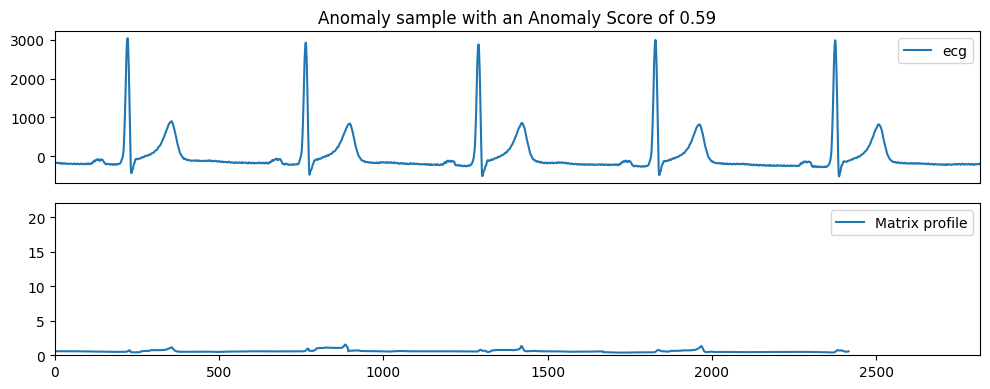


091809_w_43
Max normal: 3.0025858719690635, index: 3
Min normal: 1.696676386194915, index: 8
Max anomaly: 5.4662742642798605, index: 19
Min anomaly: 2.0950292901487355, index: 18

102214_w_36
Max normal: 2.5344357177679027, index: 11
Min normal: 1.3972432396610341, index: 6
Max anomaly: 6.753264542351261, index: 17
Min anomaly: 1.4218099922497918, index: 9

102316_w_50
Max normal: 3.384288060273574, index: 0
Min normal: 2.1603839141774137, index: 8
Max anomaly: 3.025838109239257, index: 0
Min anomaly: 2.0862119311027407, index: 8

112009_w_43
Max normal: 4.008954138297755, index: 17
Min normal: 1.580379237028833, index: 6
Max anomaly: 8.206435806045532, index: 0
Min anomaly: 2.171080695930338, index: 3

101814_m_58
Max normal: 2.1432070922182325, index: 6
Min normal: 1.229224135235991, index: 9
Max anomaly: 7.690840848910645, index: 6
Min anomaly: 2.190921035592214, index: 0

101908_m_61
Max normal: 1.821600717859664, index: 19
Min normal: 0.8490443943802459, index: 7
Max anomaly: 2.4

In [ ]:

max_normal, min_normal, max_anomaly, min_anomaly = 0, 1000, 0, 1000

for subject in Subjects.val:
    max_normal, min_normal, max_anomaly, min_anomaly = show_extremes(subject, 'ecg', 400, max_normal, min_normal, max_anomaly, min_anomaly)

Max normal: 3.2667028822303004, index: 18
Min normal: 1.3677300251661657, index: 13
Max anomaly: 8.26534924045432, index: 14
Min anomaly: 2.0835493166322103, index: 18


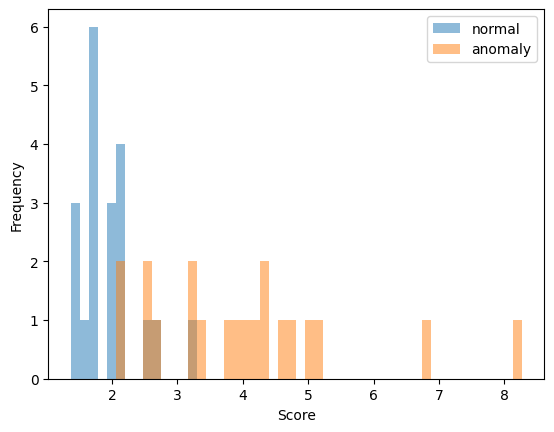

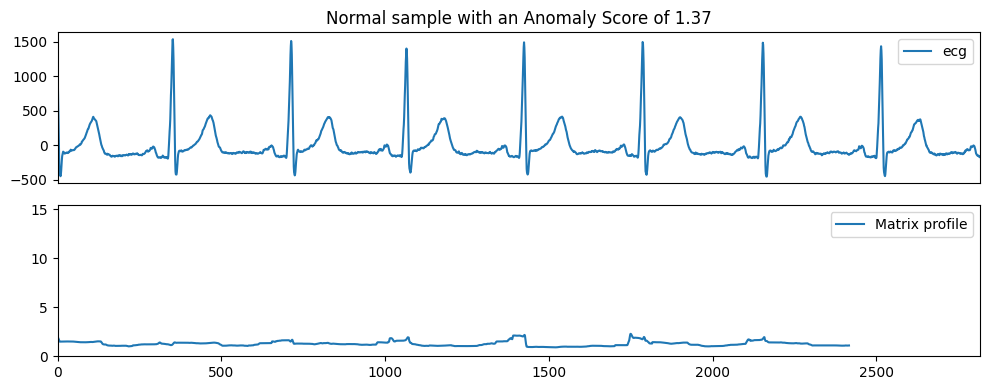

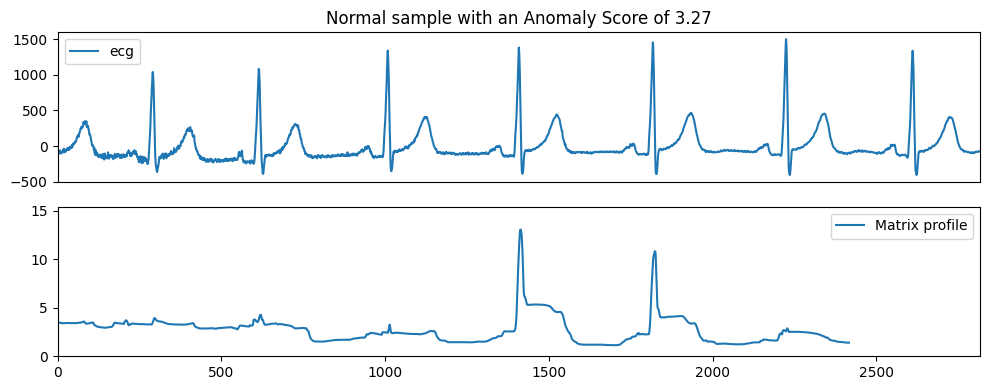

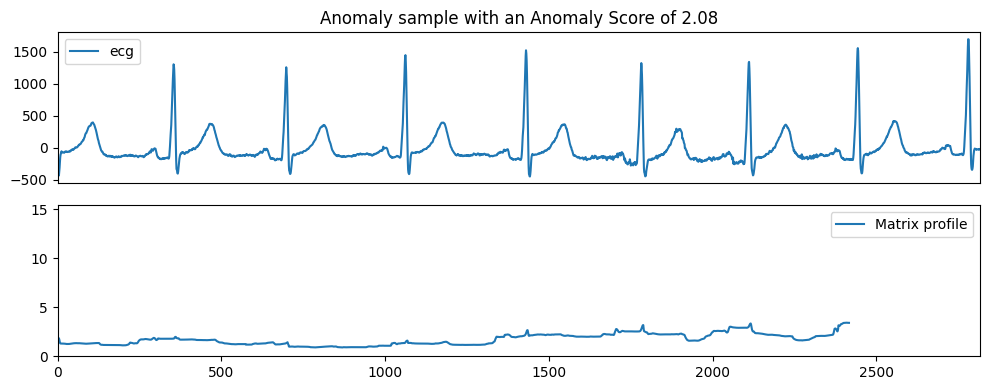

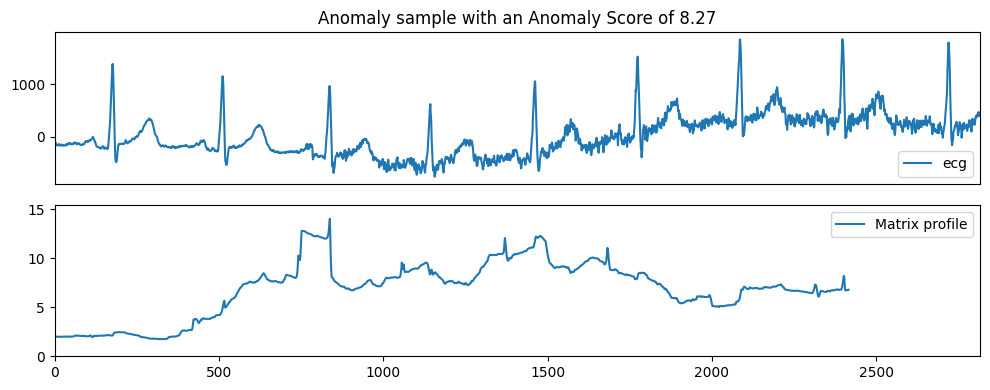

In [ ]:
show_extremes('071309_w_21', 'ecg', 400)

# STUMP - Use only a few samples as T_B
How does the performance change when we use only the n most normal samples as T_B?

In [5]:
def find_n_most_normal(subjects, signal, m, n, scores_0=None):
    """
    Find the n most normal sample (n normal samples with the lowest scores) for each subject.
    """
    if n==0:
        return 0
    subjects_most_normal = []
    if scores_0 is None:
        scores_0= stump_for_subjects(df, subjects, 4, signal, m, normal_only=True)[2]
    for i in range(len(subjects)):
        n_min_normal = np.argsort(scores_0[i])[:n]
        subjects_most_normal.append(n_min_normal)
    return subjects_most_normal

In [ ]:
auc_scores = {
    'gsr': [],
    'ecg': [],
    'emg_trapezius': []
}

signals = [
    ('gsr', 2000),
    ('ecg', 400),
    ('emg_trapezius', 500)
]

# Calculate the AUC scores for each signal for different 0 <= n <= 20
for signal, m in signals:
    sc = stump_for_subjects(df, Subjects.val, 4, signal, m, normal_only=True)[2]

    for n in range(21):
        tb_indices = find_n_most_normal(Subjects.val, signal, m, n, sc)
        _, _, subjects_scores_0, subjects_scores_1 = stump_for_subjects(df, Subjects.val, 4, signal, m, tb_indices=tb_indices)
        aucs = []
        for scores_0, scores_1 in zip(subjects_scores_0, subjects_scores_1):
            y_true = np.concatenate([np.zeros(len(scores_0)), np.ones(len(scores_1))])
            y_scores = np.concatenate([scores_0, scores_1])

            aucs.append(roc_auc_score(y_true, y_scores))
        auc_scores[signal].append((np.mean(aucs), np.std(aucs)))

# Save to a file
with open('auc_scores.pkl', 'wb') as f:
    pickle.dump(auc_scores, f)

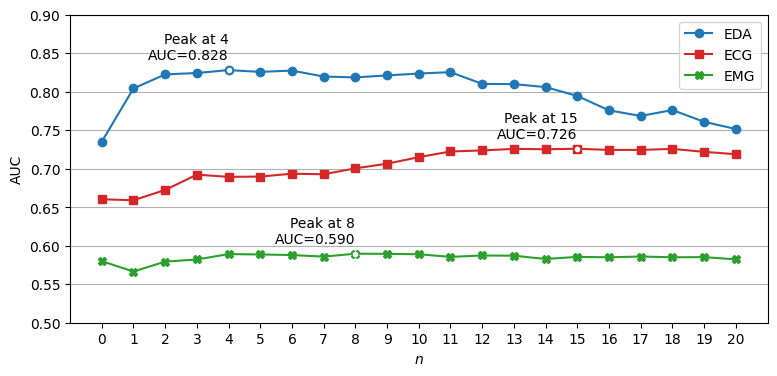

In [8]:
# Load from a file
with open('auc_scores.pkl', 'rb') as f:
    auc_scores = pickle.load(f)

gsr_means = [auc[0] for auc in auc_scores['gsr']]
gsr_stds = [auc[1] for auc in auc_scores['gsr']]
ecg_means = [auc[0] for auc in auc_scores['ecg']]
ecg_stds = [auc[1] for auc in auc_scores['ecg']]
emg_means = [auc[0] for auc in auc_scores['emg_trapezius']]
emg_stds = [auc[1] for auc in auc_scores['emg_trapezius']]

# Plot the AUC scores by n for each signal
plt.figure(figsize=(9, 4))
plt.plot(range(0, 21), gsr_means, label='EDA', marker='o', color='tab:blue')
plt.plot(range(0, 21), ecg_means, label='ECG', marker='s', color='tab:red')
plt.plot(range(0, 21), emg_means, label='EMG', marker='X', color='tab:green')

# Identify the peaks
peak_idx_gsr = np.argmax(gsr_means)
peak_idx_ecg = np.argmax(ecg_means)
peak_idx_emg = np.argmax(emg_means)

# Highlight and annotate the peaks
plt.plot(peak_idx_gsr, gsr_means[peak_idx_gsr], 'w.')  # white point marker for peak
plt.text(peak_idx_gsr, gsr_means[peak_idx_gsr]+ 0.01, f'Peak at {peak_idx_gsr}\nAUC={gsr_means[peak_idx_gsr]:.3f}', 
         verticalalignment='bottom', horizontalalignment='right')

plt.plot(peak_idx_ecg, ecg_means[peak_idx_ecg], 'w.')
plt.text(peak_idx_ecg, ecg_means[peak_idx_ecg]+ 0.01, f'Peak at {peak_idx_ecg}\nAUC={ecg_means[peak_idx_ecg]:.3f}', 
         verticalalignment='bottom', horizontalalignment='right')

plt.plot(peak_idx_emg, emg_means[peak_idx_emg], 'w.')
plt.text(peak_idx_emg, emg_means[peak_idx_emg]+ 0.01, f'Peak at {peak_idx_emg}\nAUC={emg_means[peak_idx_emg]:.3f}', 
         verticalalignment='bottom', horizontalalignment='right')

plt.xlabel('$n$')
plt.ylabel('AUC')
plt.grid(axis='y')
plt.ylim(top=0.9, bottom=0.5)
plt.legend()
plt.xticks(range(0, 21))
#plt.savefig('matrix-profile-search-n.pdf', format='pdf', bbox_inches='tight')
plt.show()

## GSR (0,4)

acc                prec                 rec  \
                           avg       std       avg       std       avg   
test supervised acc   0.824713  0.126258  0.824896  0.129228  0.855747   
train supervised acc  0.761494  0.159101  0.741965  0.151682  0.817816   
74.0-th percentile    0.737931  0.146504  0.674012  0.201509  0.744253   
mixmod                0.757759  0.133547  0.722979  0.127731  0.827011   
filter                0.753161  0.160181  0.746087  0.204380  0.688506   
karch                 0.772126  0.148818  0.753013  0.144214  0.770115   
eb                    0.735920  0.149169  0.711190  0.185815  0.740230   

                                     auc            threshold             \
                           std       avg       std        avg        std   
test supervised acc   0.176398  0.823319  0.156709  38.601645  27.502011   
train supervised acc  0.187999  0.823319  0.156709  38.244919  26.918162   
74.0-th percentile    0.321404  0.823319  0.156709  30.304704  20.410466   
mixmod                0.224608  0.823319  0.156709  21.299684  12.132324   
filter                0.317470  0.823319  0.156709  51.718466  16.826430   
karch                 0.263210  0.823319  0.156709  39.896846  11.752522   
eb                    0.264340  0.823319  0.156709  43.930943  18.309858   

                     percentile             
                            avg        std  
test supervised acc   73.965517  20.357974  
train supervised acc  73.460451  20.029076  
74.0-th percentile          NaN        NaN  
mixmod                      NaN        NaN  
filter                      NaN        NaN  
karch                       NaN        NaN  
eb                          NaN        NaN

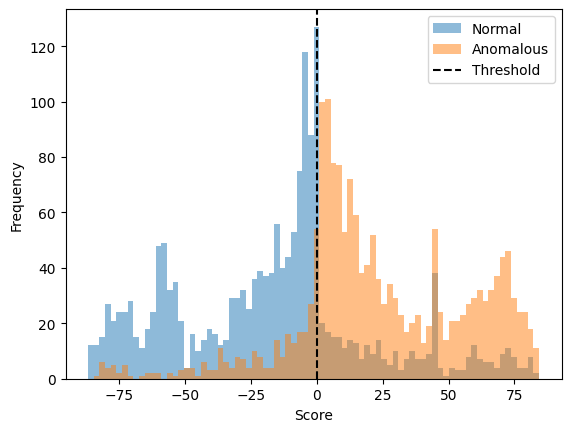

In [ ]:
tb_indices = find_n_most_normal(Subjects.all, 'gsr', 2000, 4)
results_df, scores_0, scores_1, thresholds = mpd(subjects=Subjects.all, class_id=4, signal='gsr', m=2000, algorithmType=AlgorithmType.STUMP, tb_indices=tb_indices)

display(results_df)
plot_histogram(scores_0, scores_1, thresholds)

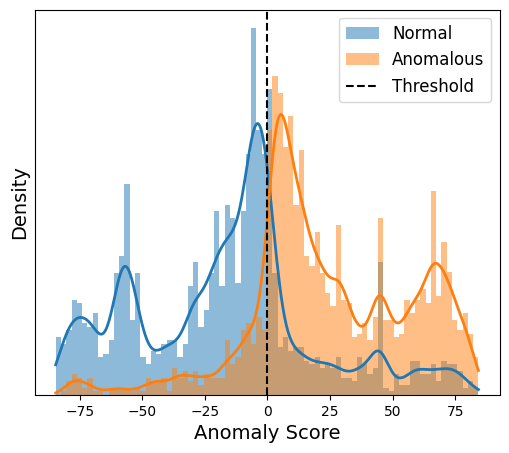

In [45]:
plot_histogram(scores_0, scores_1, thresholds)

## ECG (0,4)

acc                prec                 rec  \
                           avg       std       avg       std       avg   
test supervised acc   0.746264  0.135216  0.754560  0.177606  0.748851   
train supervised acc  0.654885  0.206150  0.637254  0.230896  0.662644   
69.4-th percentile    0.668678  0.135040  0.641756  0.121850  0.656897   
mixmod                0.652586  0.151099  0.657423  0.213987  0.519540   
filter                0.634770  0.156118  0.661908  0.298958  0.347126   
karch                 0.651724  0.157102  0.664716  0.226086  0.450575   
eb                    0.608333  0.145905  0.552042  0.262178  0.468391   

                                     auc           threshold            \
                           std       avg       std       avg       std   
test supervised acc   0.256073  0.726236  0.185034  2.159929  1.259983   
train supervised acc  0.288796  0.726236  0.185034  2.169362  1.205582   
69.4-th percentile    0.269863  0.726236  0.185034  1.958417  0.800042   
mixmod                0.320861  0.726236  0.185034  2.397528  1.006487   
filter                0.320771  0.726236  0.185034  3.376908  1.913625   
karch                 0.313902  0.726236  0.185034  2.628672  1.070632   
eb                    0.353806  0.726236  0.185034  3.333231  2.621849   

                     percentile             
                            avg        std  
test supervised acc   69.367816  22.086619  
train supervised acc  69.873563  19.238783  
69.4-th percentile          NaN        NaN  
mixmod                      NaN        NaN  
filter                      NaN        NaN  
karch                       NaN        NaN  
eb                          NaN        NaN

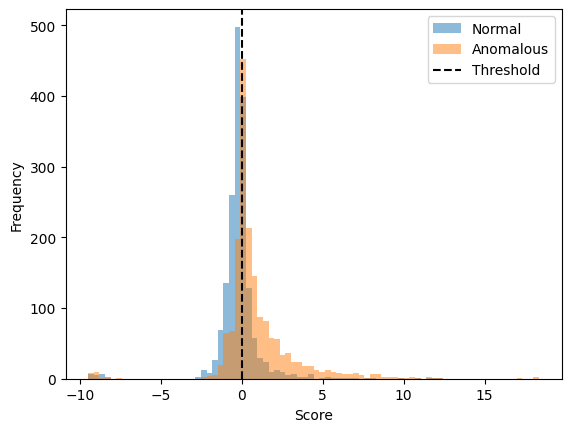

In [ ]:
tb_indices = find_n_most_normal(Subjects.all, 'ecg', 400, 15)
results_df, scores_0, scores_1, thresholds = mpd(subjects=Subjects.all, class_id=4, signal='ecg', m=400, algorithmType=AlgorithmType.STUMP, tb_indices=tb_indices)

display(results_df)
plot_histogram(scores_0, scores_1, thresholds)

## EMG (0,4)

acc                prec                 rec  \
                           avg       std       avg       std       avg   
test supervised acc   0.643103  0.095494  0.654711  0.176223  0.644828   
train supervised acc  0.528448  0.178361  0.518540  0.213409  0.535057   
58.0-th percentile    0.559483  0.112587  0.529565  0.134930  0.541379   
mixmod                0.558621  0.106797  0.544541  0.146972  0.587356   
filter                0.551149  0.104353  0.491006  0.286082  0.225287   
karch                 0.560632  0.115509  0.545427  0.188703  0.376437   
eb                    0.524138  0.093345  0.509015  0.100688  0.687356   

                                     auc            threshold            \
                           std       avg       std        avg       std   
test supervised acc   0.266634  0.582356  0.153002  21.764883  4.892817   
train supervised acc  0.265996  0.582356  0.153002  21.759231  4.684350   
58.0-th percentile    0.228715  0.582356  0.153002  21.893271  4.640804   
mixmod                0.272622  0.582356  0.153002  21.864911  3.707808   
filter                0.223847  0.582356  0.153002  24.238432  3.032619   
karch                 0.235357  0.582356  0.153002  23.082161  3.253532   
eb                    0.219354  0.582356  0.153002  21.306347  3.513856   

                     percentile             
                            avg        std  
test supervised acc   58.045977  27.253138  
train supervised acc  58.639519  23.825354  
58.0-th percentile          NaN        NaN  
mixmod                      NaN        NaN  
filter                      NaN        NaN  
karch                       NaN        NaN  
eb                          NaN        NaN

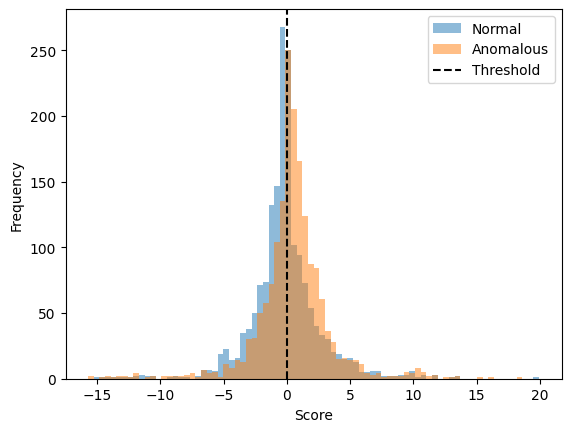

In [ ]:
tb_indices = find_n_most_normal(Subjects.all, 'emg_trapezius', 500, 8)
results_df, scores_0, scores_1, thresholds = mpd(subjects=Subjects.all, class_id=4, signal='emg_trapezius', m=500, algorithmType=AlgorithmType.STUMP, tb_indices=tb_indices)

display(results_df)
plot_histogram(scores_0, scores_1, thresholds)

# MPdist

## GSR (0,4)

c:\Python310\lib\site-packages\stumpy\core.py:3453: UserWarning: A large number of values in `P` are smaller than 1e-06.
For a self-join, try setting `ignore_trivial=True`.
  warnings.warn(msg)


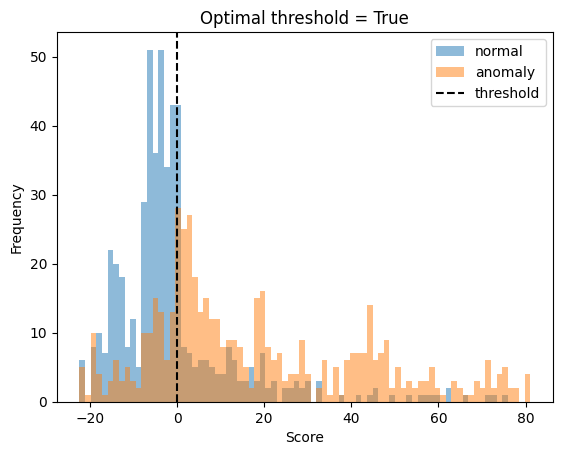

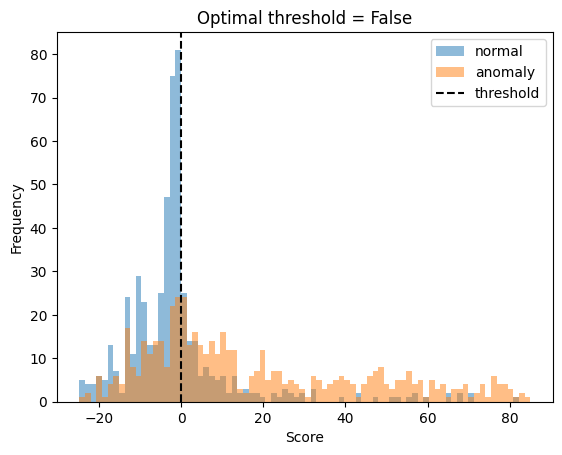

acc                prec                 rec            \
                       avg       std       avg       std       avg       std   
optimal acc       0.773077  0.126134  0.778724  0.121288  0.782692  0.228264   
75-th percentile  0.719231  0.144000  0.691573  0.148732  0.688462  0.288000   

                       auc            threshold            
                       avg       std        avg       std  
optimal acc       0.766971  0.163595  12.653966  6.572667  
75-th percentile  0.766971  0.163595  12.779438  8.469238

In [ ]:
mpd(subjects=Subjects.val, class_id=4, signal='gsr', m=2000, algorithmType=AlgorithmType.MPDIST)

## ECG (0,4)

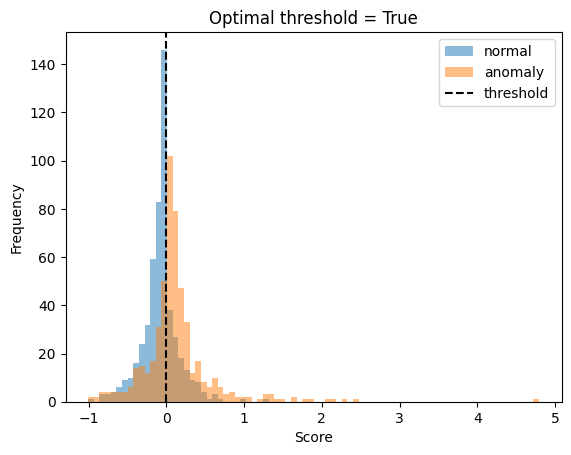

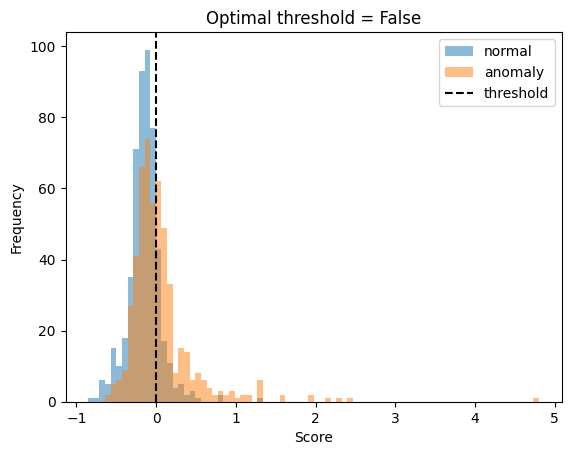

acc               prec                 rec            \
                       avg       std      avg       std       avg       std   
optimal acc       0.728846  0.110656  0.73148  0.182357  0.700000  0.257204   
85-th percentile  0.646154  0.127040  0.68445  0.178359  0.442308  0.254079   

                       auc           threshold            
                       avg       std       avg       std  
optimal acc       0.705769  0.153115  1.430237  0.523967  
85-th percentile  0.705769  0.153115  1.498268  0.510465

In [ ]:
mpd(subjects=Subjects.val, class_id=4, signal='ecg', m=400, algorithmType=AlgorithmType.MPDIST)

## EMG (0,4)

c:\Python310\lib\site-packages\stumpy\core.py:2243: RuntimeWarning: divide by zero encountered in divide
  Σ_T_inverse = 1.0 / Σ_T
c:\Python310\lib\site-packages\stumpy\core.py:3453: UserWarning: A large number of values in `P` are smaller than 1e-06.
For a self-join, try setting `ignore_trivial=True`.
  warnings.warn(msg)


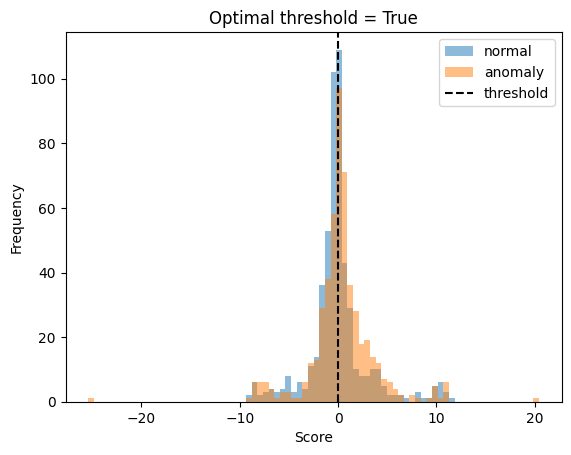

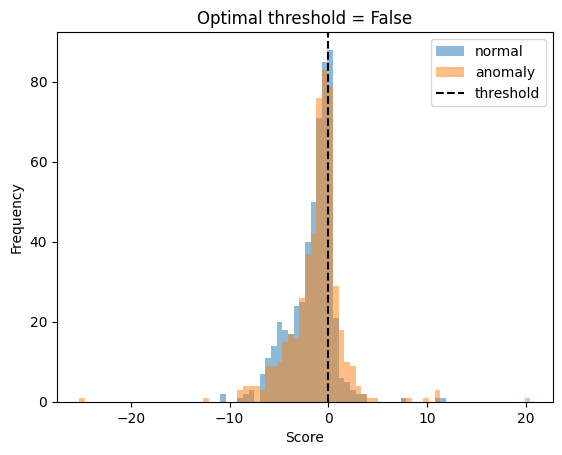

acc                prec                 rec            \
                       avg       std       avg       std       avg       std   
optimal acc       0.615385  0.077855  0.640059  0.172098  0.563462  0.294030   
85-th percentile  0.546154  0.071620  0.575122  0.209114  0.236538  0.147777   

                       auc            threshold            
                       avg       std        avg       std  
optimal acc       0.542019  0.145868  18.003882  6.558676  
85-th percentile  0.542019  0.145868  19.538249  6.680258

In [ ]:
mpd(subjects=Subjects.val, class_id=4, signal='emg_trapezius', m=500, algorithmType=AlgorithmType.MPDIST)

# Multidimensional STUMP - Use only a few samples as T_B
For each signal, use the ideal number n of most normal samples as T_B (ideal n is found by the previous experiment). Calculate the combined matrix profile by summing the z-normalized matrix profiles of each signal.

In [ ]:
tb_indices_gsr = find_n_most_normal(subjects=Subjects.all, signal='gsr', m=2000, n=4)
tb_indices_ecg = find_n_most_normal(subjects=Subjects.all, signal='ecg', m=400, n=15)
tb_indices_emg = find_n_most_normal(subjects=Subjects.all, signal='emg_trapezius', m=500, n=8)

## GSR, ECG, EMG - (0,4)

acc                prec                 rec  \
                           avg       std       avg       std       avg   
test supervised acc   0.824138  0.128957  0.824760  0.124453  0.837356   
train supervised acc  0.762931  0.169891  0.745697  0.162984  0.802874   
76.1-th percentile    0.746552  0.129220  0.715667  0.115825  0.756897   
mixmod                0.738506  0.125534  0.712714  0.137686  0.783333   
filter                0.720402  0.170130  0.751020  0.210829  0.561494   
karch                 0.752874  0.148383  0.753817  0.136064  0.695402   
eb                    0.700862  0.132366  0.671338  0.114387  0.798276   

                                     auc           threshold            \
                           std       avg       std       avg       std   
test supervised acc   0.191368  0.824655  0.153497  1.416181  1.139380   
train supervised acc  0.208078  0.824655  0.153497  1.385977  1.125747   
76.1-th percentile    0.257215  0.824655  0.153497  1.042313  0.318658   
mixmod                0.241007  0.824655  0.153497  0.836127  0.734766   
filter                0.349112  0.824655  0.153497  2.402386  1.188379   
karch                 0.287841  0.824655  0.153497  1.519294  0.293872   
eb                    0.232731  0.824655  0.153497  0.856582  0.911681   

                     percentile             
                            avg        std  
test supervised acc   76.091954  15.562726  
train supervised acc  75.358515  15.424031  
76.1-th percentile          NaN        NaN  
mixmod                      NaN        NaN  
filter                      NaN        NaN  
karch                       NaN        NaN  
eb                          NaN        NaN

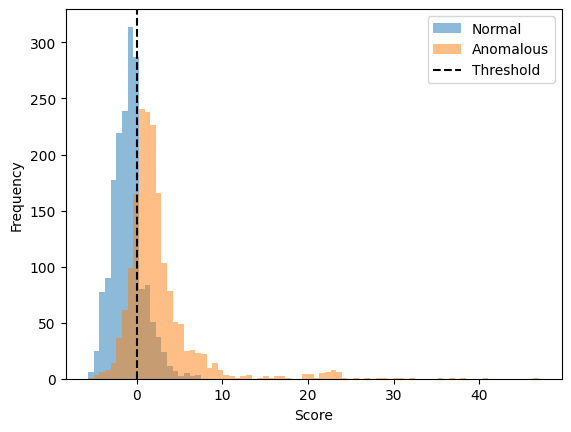

In [ ]:
results_df, scores_0, scores_1, thresholds = mpd(subjects=Subjects.all, class_id=4, signal=['gsr', 'ecg', 'emg_trapezius'], m=[2000, 400, 500], algorithmType=AlgorithmType.MULTI_STUMP, tb_indices=[tb_indices_gsr, tb_indices_ecg, tb_indices_emg])

display(results_df)
plot_histogram(scores_0, scores_1, thresholds)

## GSR, ECG - (0,4)

acc                prec                 rec  \
                           avg       std       avg       std       avg   
test supervised acc   0.835920  0.125642  0.829705  0.126543  0.864943   
train supervised acc  0.778736  0.167406  0.758543  0.163235  0.815517   
75.7-th percentile    0.759195  0.124113  0.726552  0.100985  0.780460   
mixmod                0.758908  0.121117  0.731082  0.106582  0.828161   
filter                0.741954  0.168857  0.773159  0.174450  0.612644   
karch                 0.765805  0.141275  0.766368  0.123728  0.728161   
eb                    0.735345  0.128628  0.714176  0.121901  0.780460   

                                     auc           threshold            \
                           std       avg       std       avg       std   
test supervised acc   0.163320  0.837385  0.147561  1.014952  1.255496   
train supervised acc  0.210952  0.837385  0.147561  1.028934  1.215856   
75.7-th percentile    0.247906  0.837385  0.147561  0.532714  0.389954   
mixmod                0.209913  0.837385  0.147561  0.234552  0.537480   
filter                0.340657  0.837385  0.147561  1.803380  1.052290   
karch                 0.260603  0.837385  0.147561  1.035595  0.251314   
eb                    0.227727  0.837385  0.147561  0.859969  0.895154   

                     percentile            
                            avg       std  
test supervised acc   75.689655  17.25689  
train supervised acc  76.010133  16.03198  
75.7-th percentile          NaN       NaN  
mixmod                      NaN       NaN  
filter                      NaN       NaN  
karch                       NaN       NaN  
eb                          NaN       NaN

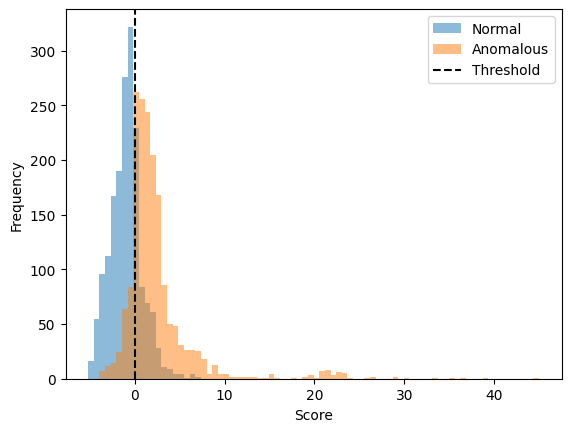

In [ ]:
results_df, scores_0, scores_1, thresholds = mpd(subjects=Subjects.all, class_id=4, signal=['gsr', 'ecg'], m=[2000, 400], algorithmType=AlgorithmType.MULTI_STUMP, tb_indices=[tb_indices_gsr, tb_indices_ecg])

display(results_df)
plot_histogram(scores_0, scores_1, thresholds)

## GSR, EMG - (0,4)

acc                prec                 rec  \
                           avg       std       avg       std       avg   
test supervised acc   0.817241  0.128782  0.817663  0.131738  0.845402   
train supervised acc  0.745115  0.188683  0.731086  0.181628  0.785057   
73.9-th percentile    0.745977  0.133900  0.705655  0.130094  0.770690   
mixmod                0.738506  0.144477  0.717709  0.141514  0.770115   
filter                0.724138  0.165851  0.732657  0.225722  0.582184   
karch                 0.756322  0.148664  0.751027  0.142211  0.708621   
eb                    0.703736  0.132858  0.663809  0.125614  0.837356   

                                     auc           threshold            \
                           std       avg       std       avg       std   
test supervised acc   0.181411  0.815029  0.158819  1.240082  0.986766   
train supervised acc  0.218947  0.815029  0.158819  1.249758  0.942150   
73.9-th percentile    0.262454  0.815029  0.158819  0.858151  0.313837   
mixmod                0.256127  0.815029  0.158819  0.832871  0.645398   
filter                0.334336  0.815029  0.158819  1.931060  0.612675   
karch                 0.280620  0.815029  0.158819  1.327660  0.171492   
eb                    0.200462  0.815029  0.158819  0.557252  0.508025   

                     percentile             
                            avg        std  
test supervised acc   73.908046  19.064701  
train supervised acc  74.113279  17.150628  
73.9-th percentile          NaN        NaN  
mixmod                      NaN        NaN  
filter                      NaN        NaN  
karch                       NaN        NaN  
eb                          NaN        NaN

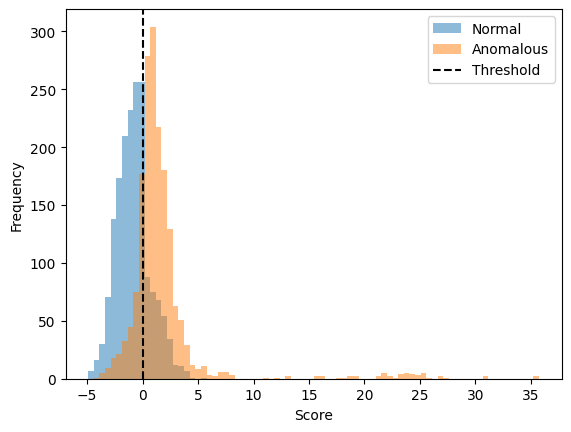

In [ ]:
results_df, scores_0, scores_1, thresholds = mpd(subjects=Subjects.all, class_id=4, signal=['gsr', 'emg_trapezius'], m=[2000, 500], algorithmType=AlgorithmType.MULTI_STUMP, tb_indices=[tb_indices_gsr, tb_indices_emg])

display(results_df)
plot_histogram(scores_0, scores_1, thresholds)

## ECG, EMG - (0,4)

acc                prec                 rec  \
                           avg       std       avg       std       avg   
test supervised acc   0.726724  0.132276  0.763176  0.140802  0.717816   
train supervised acc  0.632759  0.206549  0.633480  0.210790  0.640805   
68.6-th percentile    0.648851  0.132337  0.619146  0.135830  0.629885   
mixmod                0.643966  0.140144  0.651108  0.215645  0.550000   
filter                0.616954  0.151311  0.611985  0.318349  0.322414   
karch                 0.648563  0.146185  0.667279  0.206674  0.474713   
eb                    0.595690  0.123305  0.573284  0.137110  0.660920   

                                     auc           threshold            \
                           std       avg       std       avg       std   
test supervised acc   0.235984  0.696638  0.184185  0.646893  0.693484   
train supervised acc  0.262452  0.696638  0.184185  0.672492  0.627858   
68.6-th percentile    0.269787  0.696638  0.184185  0.624278  0.189829   
mixmod                0.310358  0.696638  0.184185  0.873538  0.674973   
filter                0.313743  0.696638  0.184185  1.725909  0.876296   
karch                 0.286063  0.696638  0.184185  1.063849  0.261885   
eb                    0.284406  0.696638  0.184185  0.581848  0.814143   

                     percentile             
                            avg        std  
test supervised acc   68.563218  23.377315  
train supervised acc  68.983742  20.287378  
68.6-th percentile          NaN        NaN  
mixmod                      NaN        NaN  
filter                      NaN        NaN  
karch                       NaN        NaN  
eb                          NaN        NaN

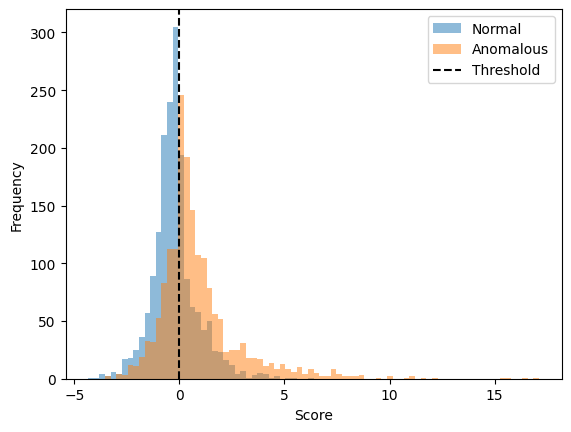

In [ ]:
results_df, scores_0, scores_1, thresholds = mpd(subjects=Subjects.all, class_id=4, signal=['ecg', 'emg_trapezius'], m=[400, 500], algorithmType=AlgorithmType.MULTI_STUMP, tb_indices=[tb_indices_ecg, tb_indices_emg])

display(results_df)
plot_histogram(scores_0, scores_1, thresholds)

In [ ]:
# Save the results in a csv file
def save_results(df, scores_0, scores_1, thresholds, filename):
    data = []
    sample_names = df.query('class_id == 0 or class_id == 4')['sample_name']

    for i, (s0, s1) in enumerate(zip(scores_0, scores_1)):
        threshold = thresholds[i]
        # 20 normal samples
        for j in range(20):
            sample_name = sample_names.iloc[40*i + j]
            subject_name = sample_name[:11]
            pain = 0
            anomaly_score = s0[j]
            anomaly_prediction = 0 if anomaly_score < threshold else 1
            # append the row
            data.append({'index': j, 'subject_name': subject_name, 'sample_name': sample_name, 'pain': pain, 'anomaly_score': anomaly_score, 'threshold': threshold, 'anomaly_prediction': anomaly_prediction})
        # 20 anomaly samples
        for j in range(20):
            sample_name = sample_names.iloc[40*i + 20 + j]
            subject_name = sample_name[:11]
            pain = 1
            anomaly_score = s1[j]
            anomaly_prediction = 0 if anomaly_score < threshold else 1
            # append the row
            data.append({'index': j, 'subject_name': subject_name, 'sample_name': sample_name, 'pain': pain, 'anomaly_score': anomaly_score, 'threshold': threshold, 'anomaly_prediction': anomaly_prediction})

    results_df = pd.DataFrame(data)
    results_df.to_csv(filename, index=False)

save_results(df, scores_0, scores_1, thresholds, 'eda-ecg-results.csv')

## Plot Point-wise Anomaly Scores/ Matrix Profile

In [6]:
def get_mp_stats(sample_name, subject_name, signal, m, n, index):
    tb_i = find_n_most_normal([subject_name], signal, m, n)
    subjects_mps_0, subjects_mps_1, scores_0, scores_1 = stump_for_subjects(df, [subject_name], 4, signal, m, tb_indices=tb_i)
    res, _ = evaluate(scores_0, scores_1, test_supervised_acc_threshold)

    if 'PA4' in sample_name:
        mp = subjects_mps_1[0][index]
    else:
        mp = subjects_mps_0[0][index]

    return {
        'min_mp': np.min(np.concatenate(subjects_mps_0 + subjects_mps_1)),
        'threshold': res['threshold']['avg'][0],
        'max_mp': np.max(np.concatenate(subjects_mps_0 + subjects_mps_1)),
        'mp': mp.astype(np.float64),
    }

In [28]:
def plot_sample(sample_name, index):
    subject_name = sample_name[:11]
    sample = df[(df['sample_name'] == sample_name)].iloc[0]
    bio_signals = sample['bio_signals']

    fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 7), gridspec_kw={'hspace':0.4})

    signals = ['gsr', 'ecg', 'emg_trapezius']
    signal_legend = ['EDA', 'ECG', 'EMG']
    colors = ['tab:blue', 'tab:red', 'tab:green']

    # create an array of signal points
    signal_points = np.arange(len(bio_signals['gsr']))

    for i, (signal, color) in enumerate(zip(signals, colors)):
        # plot the signal
        axs[i].plot(signal_points, bio_signals[signals[i]], color=color)
        axs[i].set_ylabel('Amplitude')
        axs[i].grid(visible=True, which='both', axis='x', linestyle='-', color='lightgray')
        axs[i].set_yticks([])
        axs[i].set_xlim([signal_points[0], signal_points[-1]])
        axs[i].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        axs[i].legend([signal_legend[i]], loc='upper left')

        # compute the matrix profile for the signal
        if(signal == 'gsr'):
            mp_results = get_mp_stats(sample_name, subject_name, 'gsr', m=2000, n=4, index=index)
        elif(signal == 'ecg'):
            mp_results = get_mp_stats(sample_name, subject_name, 'ecg', m=400, n=15, index=index)
        else:
            mp_results = get_mp_stats(sample_name, subject_name, 'emg_trapezius', m=500, n=8, index=index)

        # plot the matrix profile
        anomaly_scores = mp_results['mp']
        axs_score = fig.add_axes([axs[i].get_position().x0, axs[i].get_position().y0 - (0.04), axs[i].get_position().width, 0.03])
        cmap = plt.get_cmap('coolwarm')
        mp_results['threshold'] = mp_results['threshold'] + 0.01 if mp_results['threshold'] == mp_results['min_mp'] else mp_results['threshold']
        norm = mcolors.TwoSlopeNorm(vmin=mp_results['min_mp'], vcenter=mp_results['threshold'], vmax=mp_results['max_mp'])
        axs_score.imshow(anomaly_scores[np.newaxis, :], aspect='auto', cmap=cmap, extent=[signal_points[0], signal_points[-1], 0, 1], norm=norm)
        axs_score.set_yticks([])
        axs_score.set_xticks([0, 500, 1000, 1500, 2000, 2500])
        if i == 2:
            axs_score.set_xlabel('Time Points')
        else:
            axs_score.set_xticklabels([])

    plt.show()

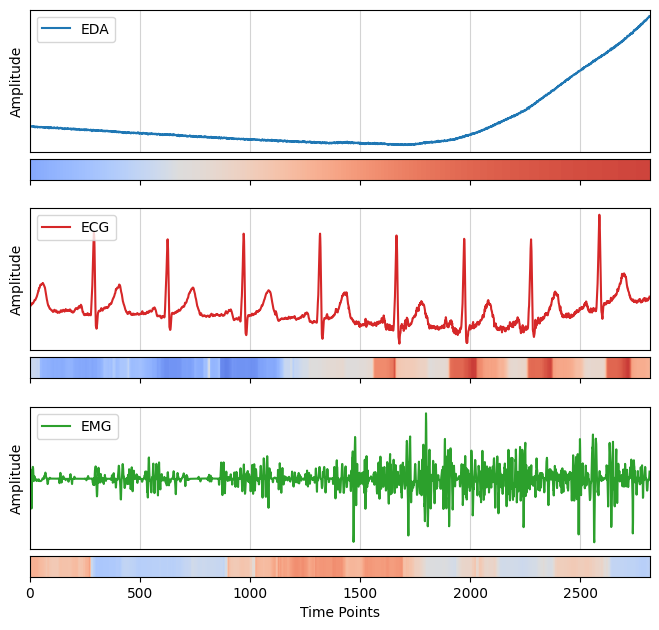

In [29]:
plot_sample('071309_w_21-PA4-068', 17)

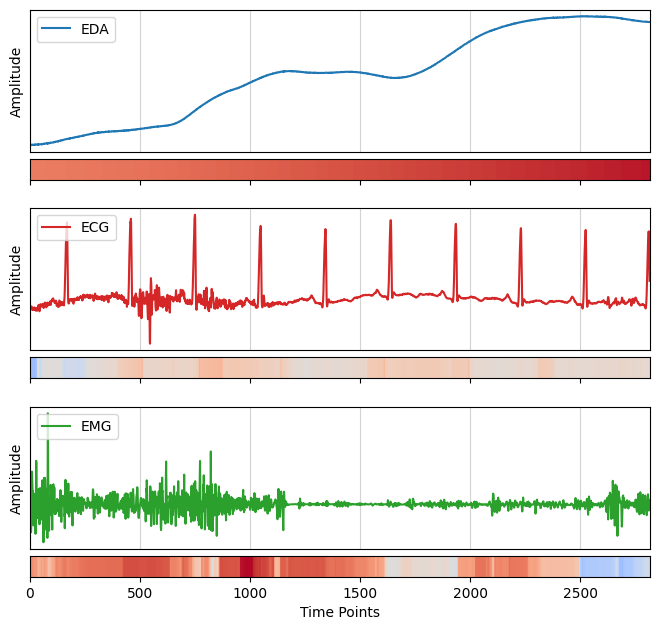

In [30]:
plot_sample('072609_w_23-PA4-070', 16)

### Anomaly labeled sample with the highest anomaly score

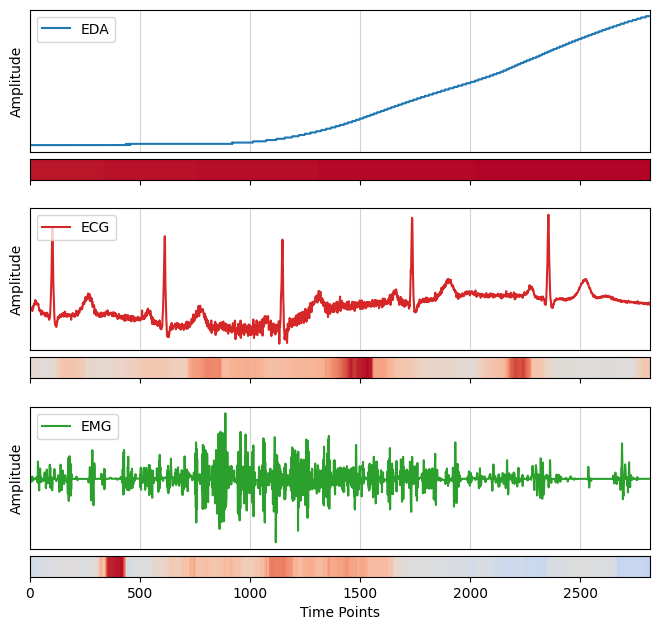

In [31]:
plot_sample('112914_w_51-PA4-057', 14)

### Anomaly labeled sample with the lowest anomaly score

c:\Users\yanni\AppData\Local\Programs\Python\Python310\lib\site-packages\stumpy\core.py:3453: UserWarning: A large number of values in `P` are smaller than 1e-06.
For a self-join, try setting `ignore_trivial=True`.
  warnings.warn(msg)
c:\Users\yanni\AppData\Local\Programs\Python\Python310\lib\site-packages\stumpy\core.py:3453: UserWarning: A large number of values in `P` are smaller than 1e-06.
For a self-join, try setting `ignore_trivial=True`.
  warnings.warn(msg)


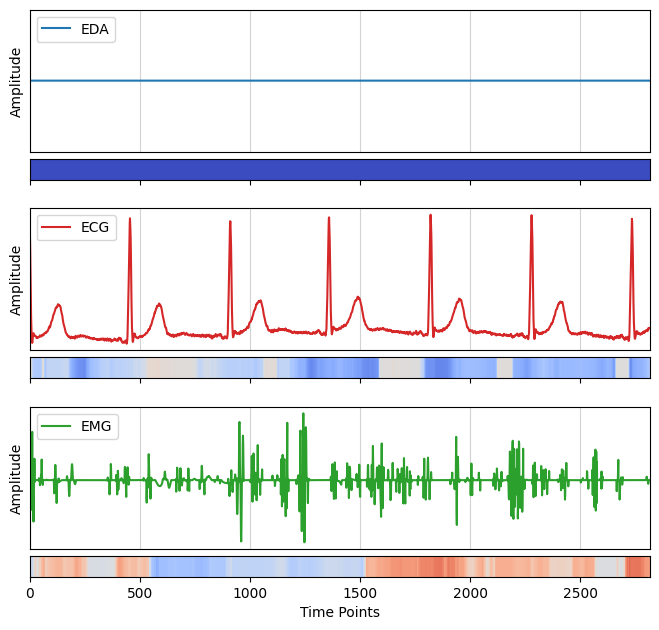

In [33]:
plot_sample('092509_w_51-PA4-059', 15)

C:\Users\yanni\AppData\Local\Temp\ipykernel_17772\3271728991.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


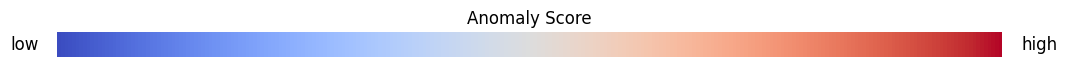

In [ ]:
fig = plt.figure(figsize=(10.5, 0.5))
ax = fig.add_axes([0.05, 0.5, 0.9, 0.5])

cmap = plt.get_cmap('coolwarm')
norm = mcolors.Normalize(vmin=0, vmax=1)
cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax, orientation='horizontal')
cb.set_label('Anomaly Score', labelpad=-34, y=0.5, rotation=0, fontsize=12)
ax.text(-0.02, 0.5, 'low', va='center', ha='right', transform=ax.transAxes, fontsize=12)
ax.text(1.02, 0.5, 'high', va='center', ha='left', transform=ax.transAxes, fontsize=12)
ax.set_xticks([])
ax.set_frame_on(False)

plt.tight_layout()
#plt.savefig('mp-anomaly_score_colorbar.pdf', format='pdf', bbox_inches='tight')
plt.show()